In [1]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import os
import scipy.signal as sgn
from tqdm import tqdm
from biosppy.signals import ecg
from scipy.interpolate import CubicSpline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from scipy.signal import cheby1, filtfilt, medfilt, decimate
import tensorflow as tf


In [2]:
# get the list of files to be processed
ecgs_df = pd.read_csv("apnea-ecg\\1.0.0\\list", header=None, names=['id'])
# add filepaths so we can retrieve the files later on
ecgs_df['filepath'] = ecgs_df['id'].apply(lambda x: str("C:\\apnea-ecg\\1.0.0\\" + x))
# divide the dataset into train and test dataset as per instrucctions in the data set
ecgs_df['dataset'] = ecgs_df['id'].apply(lambda x: "test" if 'x' in x else "train")

In [3]:
# display the first 5 entries
ecgs_df.head()

,id,filepath,dataset
0,a01,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
1,a02,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
2,a03,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
3,a04,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
4,a05,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train


In [4]:
# display number of training and testing samples
freq = ecgs_df['dataset'].value_counts()
print(freq)

train    35
test     35
Name: dataset, dtype: int64


In [5]:
def load_ecg(file):
    # load the ecg

    # load the ecg
    record = wfdb.rdrecord(file)

    # load the annotation
    annotation = wfdb.rdann(file, extension="apn")

    # extract the signal
    p_signal = record.p_signal

    # verify frequency is 100
    assert record.fs == 100, 'sample freq is not 100'

    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [8]:
# 2. Save ECG signal as image
def save_ecg_as_image(signal, filename):
    plt.figure(figsize=(6, 3))  
    plt.plot(signal)  
    plt.title('ECG Signal')  
    plt.xlabel('Time (ms)')  
    plt.ylabel('Amplitude')  
    plt.grid(False)  
    plt.axis('off')  
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)  
    plt.close()

In [9]:
# Split into training and test set as per instructions
train_ecg_paths = ecgs_df[ecgs_df['dataset'] == 'train']['filepath'].tolist()
test_ecg_paths = ecgs_df[ecgs_df['dataset'] == 'test']['filepath'].tolist()


In [ ]:
import os


# 3. Generate and save ECG images, skipping already saved images
def generate_ecg_images(pts, num_sec, fs, save_dir):
    for pt in pts:
        p_signal, atr_sym, atr_sample = load_ecg(pt)
        # Grab the first signal channel
        p_signal = p_signal[:, 0]
        # Extract the base file name (e.g., 'a01') without directory
        base_filename = os.path.basename(pt).split('.')[0]
        
        for i, sample in enumerate(atr_sample):
            start_idx = max(0, sample - num_sec * fs)
            end_idx = min(len(p_signal), sample + num_sec * fs)
            signal_segment = p_signal[start_idx:end_idx]
            
            # File path where the image will be saved
            filename = f"{save_dir}/ecg_image_{base_filename}_{i}.png"
            
            # Skip saving if the file already exists
            if os.path.exists(filename):
                print(f"File {filename} already exists, skipping.")
                continue  # Move on to the next sample
            
            # Save the image if it doesn't exist
            save_ecg_as_image(signal_segment, filename)
            print(f"Saved {filename}")

# Ensure save directory exists
save_dir = ''
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Continue from where you left off
generate_ecg_images(train_ecg_paths, num_sec=10, fs=100, save_dir=save_dir)
generate_ecg_images(test_ecg_paths, num_sec=10, fs=100, save_dir=save_dir)

In [11]:
# 4. Data Preparation with ImageDataGenerator
height, width = 180, 360  # Adjust image dimensions to match your saved images

In [12]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  


In [13]:
train_generator = datagen.flow_from_directory(
    '/ecg-img',
    target_size=(height, width),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

Found 0 images belonging to 0 classes.


In [23]:
import shutil


def extract_labels(file):
    # Load the annotation file (.apn)
    annotation = wfdb.rdann(file, extension='apn')
    # Extract the annotation symbols ('N' for normal, 'A' for apnea)
    labels = annotation.symbol
    # Map labels ('A' -> 1 for apnea, 'N' -> 0 for normal)
    label_map = {'A': 1, 'N': 0}
    return [label_map[symbol] for symbol in labels]

In [24]:
def move_images_to_class_dirs(image_dir, ecg_paths, save_dir):
    for ecg_file in ecg_paths:
        base_filename = os.path.basename(ecg_file).split('.')[0]  # Get base name (e.g., a01, x01)
        labels = extract_labels(ecg_file)  # Extract labels from the .apn file

        for i, label in enumerate(labels):
            image_name = f"ecg_image_{base_filename}_{i}.png"
            src = os.path.join(image_dir, image_name)
            
            if not os.path.exists(src):
                print(f"Image {src} not found, skipping.")
                continue
            
            # Create the target directory based on the label (0 or 1)
            target_dir = os.path.join(save_dir, str(label))
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            
            dest = os.path.join(target_dir, image_name)
            shutil.move(src, dest)
            print(f"Moved {image_name} to {target_dir}")

In [ ]:
# Set your directories (adjust paths as needed)
train_image_dir = 'ecg-img/train_set'
test_image_dir = 'ecg-img/test_set'

# Generate training ECG paths using a for loop with different counts for 'a', 'b', and 'c'
train_ecg_paths = []

# 'a' prefix has 20 files, so it will go from a01.apn to a20.apn
for i in range(1, 21):
    train_ecg_paths.append(f"apnea-ecg/1.0.0/a{str(i).zfill(2)}")

# 'b' prefix has 5 files, so it will go from b01.apn to b05.apn
for i in range(1, 6):
    train_ecg_paths.append(f"/apnea-ecg/1.0.0/b{str(i).zfill(2)}")

# 'c' prefix has 10 files, so it will go from c01.apn to c10.apn
for i in range(1, 11):
    train_ecg_paths.append(f"apnea-ecg/1.0.0/c{str(i).zfill(2)}")

# Generate testing ECG paths using a for loop (assuming there are 35 files in the test set)
test_ecg_paths = []
for i in range(1, 36):
    test_ecg_paths.append(f"apnea-ecg/1.0.0/x{str(i).zfill(2)}")
# Step 1: Organize training images into class directories
move_images_to_class_dirs(train_image_dir, train_ecg_paths, train_image_dir)

# Step 2: Organize test images into class directories
move_images_to_class_dirs(test_image_dir, test_ecg_paths, test_image_dir)

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# Set directories for train and test images
train_dir = r'ecg-img\train_set'
test_dir = r'ecg-img\test_set'

# Image dimensions
img_height = 128
img_width = 128
batch_size = 32

# Data generators for loading images
train_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255)


In [36]:
# Load training images with shuffle
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True  
)

Found 17045 images belonging to 2 classes.


In [37]:
# Load test images without shuffle (as it’s for evaluation)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  
)

Found 17268 images belonging to 2 classes.


In [45]:
# Model building: Combining Conv2D and LSTM layers
model = models.Sequential()

# Conv2D layers to extract spatial features from images
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.BatchNormalization())  
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the data before feeding into LSTM
model.add(layers.Flatten())  

# LSTM layers to process temporal dependencies
model.add(layers.RepeatVector(1))  
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))

# Dense layers for classification
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  

# Model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                      

In [46]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [47]:
# Define a checkpoint to save the best model during training
checkpoint = ModelCheckpoint(
    r"Model_CheckPoint\best_model.h5",  
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


In [48]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

Epoch 1/20
533/533 [==============================] - ETA: 0s - loss: 0.6315 - accuracy: 0.6474
Epoch 1: val_loss improved from inf to 0.73318, saving model to C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\1.0.0\Model_CheckPoint\best_model.h5
533/533 [==============================] - 719s 1s/step - loss: 0.6315 - accuracy: 0.6474 - val_loss: 0.7332 - val_accuracy: 0.6137


C:\Users\abbas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
533/533 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7054
Epoch 2: val_loss improved from 0.73318 to 0.68378, saving model to C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\1.0.0\Model_CheckPoint\best_model.h5
533/533 [==============================] - 745s 1s/step - loss: 0.5558 - accuracy: 0.7054 - val_loss: 0.6838 - val_accuracy: 0.6050
Epoch 3/20
533/533 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.7218
Epoch 3: val_loss did not improve from 0.68378
533/533 [==============================] - 718s 1s/step - loss: 0.5337 - accuracy: 0.7218 - val_loss: 1.5947 - val_accuracy: 0.6207
Epoch 4/20
533/533 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.7448
Epoch 4: val_loss improved from 0.68378 to 0.63635, saving model to C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\1.0.0\Model_CheckPoint\best_model.h5
533/533 [==============================] - 548s 1s/step - loss: 0.4905 - accuracy: 0.7448 - val_los

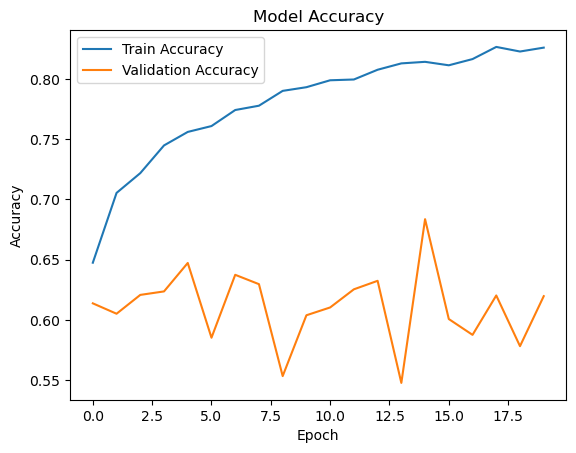

In [49]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


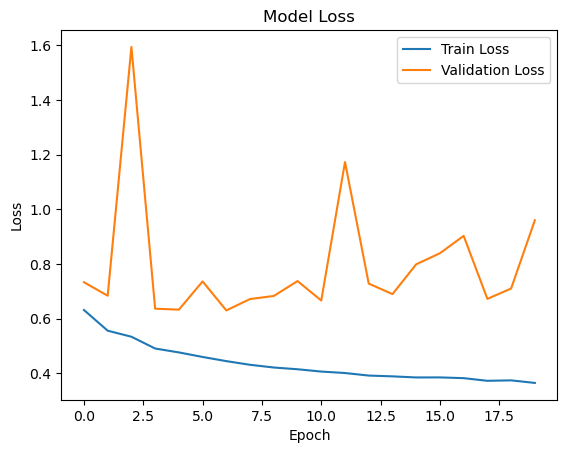

In [50]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()